# Hydrological model inversion
In this notebook, I'll show how it is possible to infer rainfall from streamflow data. You will need the usual scientific Python libraries: Matplotlib, Numpy and Pandas. You can easily get them by installing the [Anaconda](http://continuum.io/downloads) distribution.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import pandas as pd
from pandas import DataFrame
import math

## Time goes from present to future...
When we talk about inference, we usually mean that we want to find the causes that had an effect on a particular observation. In our case, we know that the streamflow at the outlet of a catchment is primarily caused by the rain that fell on this catchment. The transformation of rainfall into streamflow is quite complex: it depends on the morphological and geological characteristics of the catchment, but also on the hydrological *state* of the catchment. By *state*, I mean that the catchment will not respond to a rainy event in the same way when it has not rained for a month and when it has been raining for a month. In the latter case, a flood could occur, while in the former case, the catchment will gently buffer the rainfall and smoothly release it in the following days.

Hydrological models can be divided into two main categories:
* the ones that were designed with a bottom-up approach (*physical and distributed models*). In a way, this is the most logical way, because we think that if we can understand the details, then we can understand the whole system by describing how its components are interrelated. Those models are usually CPU intensive because the watershed is divided into small cells on a grid and the model runs on each cell (distributed model). The theory is nice, but in practice there are so many unknown parameters that some kind of calibration has to be done for the model to work.
* the ones that were designed with a top-down approach (*lumped and conceptual models*). Because the final goal of the model is to mimic the observed streamflow, let's have a look at the rainfall and the streamflow time series.

<function matplotlib.pyplot.show>

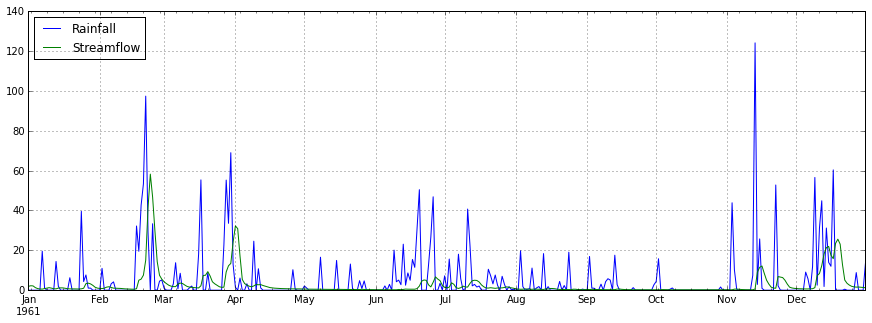

In [10]:
%matplotlib inline
peq = pd.read_pickle('peq.pkl')
peq.loc['1961', ['p', 'q']].rename(columns = {'p': 'Rainfall', 'q': 'Streamflow'}).plot(figsize = (15, 5))
plt.show

We can see that the streamflow signal is a filtered version of the rainfall signal: when there is a rainfall *pulse*, it takes time to propagate to the outlet of the watershed, and it is smoothed. Everything appears as if the water had to go through a reservoir. Indeed, the catchment is able to store water into the ground, and can act as a buffer or as a by-pass depending on its saturation level. Also, depending on where the rain falls on the catchment, it needs time to be routed to the outlet, either through infiltration or through runoff. Thus the concepts cannot be disconnected from the physics. There must be some sort of matching between the model concepts and the physical characteristics of the catchment, because it is difficult to imagine that by inventing a completely false mechanism we could reproduce the reality.

[Irstea](http://webgr.irstea.fr/?lang=en) has developed the [GR4J](http://dx.doi.org/10.1016/S0022-1694%2803%2900225-7). It is a daily lumped model which has 4 parameters to calibrate.

In [31]:
from IPython.display import HTML
HTML('<iframe src="./schema_gr4j.pdf" width=600 height=800></iframe>')

In [2]:
def run_gr4j(x, p, e, q, s, uh1_tab, uh2_tab, l, m):
    for t in range(p.size):
        if p[t] > e[t]:
            pn = p[t] - e[t]
            en = 0.
            tmp = s[0] / x[0]
            ps = x[0] * (1. - tmp * tmp) * math.tanh(pn / x[0]) / (1. + tmp * math.tanh(pn / x[0]))
            s[0] += ps
        elif p[t] < e[t]:
            ps = 0.
            pn = 0.
            en = e[t] - p[t]
            tmp = s[0] / x[0]
            es = s[0] * (2. - tmp) * np.tanh(en / x[0]) / (1. + (1. - tmp) * np.tanh(en / x[0]))
            tmp = s[0] - es
            if tmp > 0.:
                s[0] = tmp
            else:
                s[0] = 0.
        else:
            pn = 0.
            en = 0.
            ps = 0.
        tmp = (4. * s[0] / (9. * x[0]))
        perc = s[0] * (1. - (1. + tmp * tmp * tmp * tmp) ** (-1. / 4.))
        s[0] -= perc
        pr_0 = perc + pn - ps
        q9 = 0.
        q1 = 0.
        for i in range(m):
            if i == 0:
                pr_i = pr_0
            else:
                pr_i = s[2 + i - 1]
            if i < l:
                q9 += uh1_tab[i] * pr_i;
            q1 += uh2_tab[i] * pr_i;
        q9 *= 0.9
        q1 *= 0.1
        f = x[1] * ((s[1] / x[2]) ** (7. / 2.))
        tmp = s[1] + q9 + f
        if tmp > 0.:
            s[1] = tmp
        else:
            s[1] = 0.
        tmp = s[1] / x[2]
        qr = s[1] * (1. - ((1. + tmp * tmp * tmp * tmp) ** (-1. / 4.)))
        s[1] -= qr
        tmp = q1 + f
        if tmp > 0.:
            qd = tmp
        else:
            qd = 0.
        q[t] = qr + qd
        s[3:] = s[2:-1]
        if s.size > 2:
            s[2] = pr_0

class gr4j:
    def sh1(self, t):
        if t == 0:
            res = 0.
        elif t < self.x[3]:
            res = (float(t) / self.x[3]) ** (5. / 2.)
        else:
            res = 1.
        return res
    def sh2(self, t):
        if t == 0:
            res = 0.
        elif t < self.x[3]:
            res = 0.5 * ((float(t) / self.x[3]) ** (5. / 2.))
        elif t < 2. * self.x[3]:
            res = 1. - 0.5 * ((2. - float(t) / self.x[3]) ** (5. / 2.))
        else:
            res = 1.
        return res
    def uh1(self, j):
        return self.sh1(j) - self.sh1(j - 1)
    def uh2(self, j):
        return self.sh2(j) - self.sh2(j - 1)
    def __init__(self, x, s = None):
        self.x = np.array(x)
        if s == None:
            self.s = np.array([0., 0.] + [0.] * int(2. * self.x[3]))
        else:
            self.s = np.array(s)
        self.l = int(self.x[3]) + 1
        self.m = int(2. * self.x[3]) + 1
        self.uh1_tab = np.empty(self.l)
        self.uh2_tab = np.empty(self.m)
        for i in range(self.m):
            if i < self.l:
                self.uh1_tab[i] = self.uh1(i + 1)
            self.uh2_tab[i] = self.uh2(i + 1)
    def run(self, p, e):
        q = np.empty_like(p)
        run_gr4j(self.x, p, e, q, self.s, self.uh1_tab, self.uh2_tab, self.l, self.m)
        return q
    def set_state(self, s):
        self.s[:] = s[:]
    def get_state(self):
        return np.array(self.s)
    def set_conf(self, conf):
        if conf == 0:
            self.s[:] = 0.
        elif conf == 1:
            self.s[0] = self.x[0] / 2.
            self.s[1] = self.x[2] / 2.
            self.s[2:] = 0.

In [3]:
class p_mod0:
    def __init__(self, p):
        self.p = np.array(p)
    def run(self, nb):
        return self.p[np.random.random_integers(0, self.p.size - 1, size = nb)]

In [7]:
peq = pd.read_pickle('pe.pkl')
gr4j_x = [334., -0.6, 55., 3.5]
q_mod = gr4j(gr4j_x)
q_mod.set_conf(1)
peq['q'] = q_mod.run(peq.p, peq.e)

## ... and from present to past

In [8]:
class invert:
    def __init__(self):
        self.i = 0
        self.j = 0
        self.q_state = q_mod.get_state()
        self.min_err = np.inf
        self.next_q_state = None
    def run(self, dummy):
        if self.j == 0:
            self.min_err = np.inf
            p_show[:] = np.nan
            q_show[:] = np.nan
            for k in range(nmc):
                lines_p[k].set_ydata(np.array(p_show))
                lines_q[k].set_ydata(np.array(q_show))
        q_mod.set_state(self.q_state)
        this_p = p_mod.run(win)
        this_q = q_mod.run(this_p[0:1], peq.e[self.i:self.i + 1])
        this_state = q_mod.get_state()
        this_q = np.append(this_q, q_mod.run(this_p[1:], peq.e[self.i + 1:self.i + win]))
        this_err = np.mean((this_q - peq.q[self.i:self.i + win]) ** 2)
        p_show[self.i:self.i + win] = this_p
        q_show[self.i:self.i + win] = this_q
        p_show[self.i - 1] = p_inv[self.i - 1]
        q_show[self.i - 1] = q_inv[self.i - 1]
        if this_err < self.min_err:
            self.min_err = this_err
            self.next_q_state = this_state
            p_inv[self.i:self.i + win] = this_p
            q_inv[self.i:self.i + win] = this_q
        if self.j == nmc - 1:
            self.q_state = self.next_q_state
            self.i += 1
        line_p_inv.set_ydata(p_inv)
        line_q_inv.set_ydata(q_inv)
        line_p_ref.set_ydata(peq.p)
        line_q_ref.set_ydata(peq.q)
        lines_p[self.j].set_ydata(p_show)
        lines_q[self.j].set_ydata(q_show)
        self.j = (self.j + 1) % nmc
        return [line_p_inv, line_q_inv, line_p_ref, line_q_ref] + lines_p + lines_q

In [ ]:
win = 5
nmc = 100
p_show = np.empty_like(peq.p)
p_show[:] = np.nan
q_show = np.empty_like(peq.p)
q_show[:] = np.nan
p_inv = np.empty_like(peq.p)
p_inv[:] = np.nan
q_inv = np.empty_like(peq.p)
q_inv[:] = np.nan
p_mod = p_mod0(peq.p)
q_mod = gr4j(gr4j_x)
q_mod.set_conf(1)

inv = invert()
run_invert = inv.run

lines_p = [None] * nmc
lines_q = [None] * nmc
x = np.arange(len(peq))
y = np.empty_like(x)
y[:] = np.nan
plt.close('all')
fig = plt.figure(figsize = (15, 5))
ax1 = fig.add_subplot(111)
for i in range(nmc):
    lines_p[i], = ax1.plot(x, y, color = 'green', alpha = .1)
line_p_ref, = ax1.plot(x, y, color = 'red', label = '$P_{ref}$')
line_p_inv, = ax1.plot(x, y, color = 'blue', label = '$P_{inv}$')
ax1.set_ylim([200, -4])
ax2 = ax1.twinx()
for i in range(nmc):
    lines_q[i], = ax2.plot(x, y, color = 'green', alpha = .1)
line_q_ref, = ax2.plot(x, y, color = 'red', label = '$Q_{ref}$')
line_q_inv, = ax2.plot(x, y, color = 'blue', label = '$Q_{inv}$')
ax2.set_ylim([-1, 60])

def init():
    line_p_inv.set_ydata(y)
    line_q_inv.set_ydata(y)
    line_p_ref.set_ydata(y)
    line_q_ref.set_ydata(y)
    for i in range(nmc):
        lines_p[i].set_ydata(y)
        lines_q[i].set_ydata(y)
    return [line_p_inv, line_q_inv, line_p_ref, line_p_ref] + lines_p + lines_q

ani = animation.FuncAnimation(fig, run_invert, range(nmc * (len(peq) - win + 1)), init_func = init, interval = 0, blit = True)
ax1.legend(loc = 'lower right')
ax2.legend(loc = 'upper right')
ax1.set_ylabel('mm/day')
ax2.set_ylabel('mm/day')
ax1.set_xlabel('Time [days]')
plt.show()